## HW3 Automatic Mixed Precision (Example)

## Import libraries

In [2]:
# Import libraries
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

In [3]:
#Check device: GPU(cuda) or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load dataset

In [4]:
# dataset upload
# data augmentation
# data normalization
transform_train = transforms.Compose([ # train set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([ # validation set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


transform_test = transforms.Compose([ # test set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_val)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# split the training set into training and validation sets
train_size = int(0.9 * len(train_set)) # use only 5000 images for validation
val_size = len(train_set) - train_size
train_set, valset = torch.utils.data.random_split(train_set, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 128, shuffle=True) # use shuffle only for train
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [7]:
# sample image plot
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

In [8]:
CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

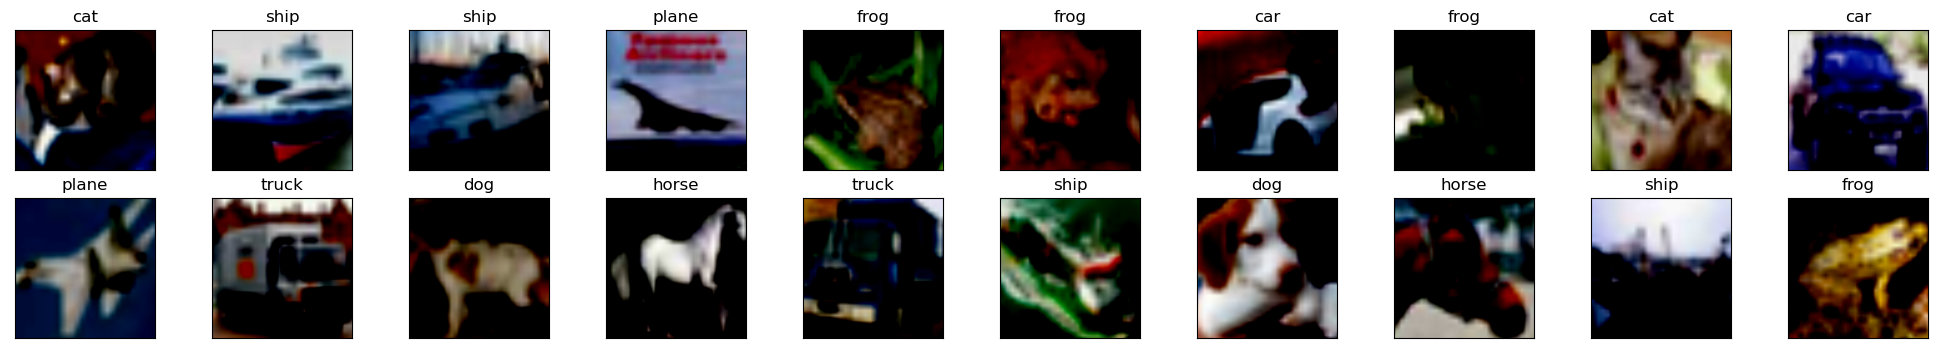

In [9]:
# sample test image plot (normalized ones)
data_iter = iter(test_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20): # normalized test images
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(CLASS_NAMES[labels[i].item()])

## Define AlexNet

In [10]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
# Initialize the model and optimizer
model = AlexNet().to(device) # use adam
optimizer = optim.Adam(model.parameters(), lr=0.001) # set learning rate as 0.001

## Check structure of the model

In [12]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

## Train the model

In [13]:
# Train the model
criterion = nn.CrossEntropyLoss()
num_epoch = 10
PATH =  "./alexNet_pytorch.pt"
import math
total_batches = math.ceil(len(train_set) / 128)
total_steps = num_epoch * total_batches

In [14]:
scaler = torch.cuda.amp.GradScaler(enabled=True) # Use loss scaling

In [20]:
import time

# Initialize total training time & accuracy
total_training_time = 0.0
total_accuracy = 0.0

best_val_acc = 0.0  # initialize to lowest possible value
for epoch in range(num_epoch):
    epoch_start_time = time.time()  # Record the start time of the epoch

    # Train the model
    train_loss = 0.0
    train_acc = 0.0
    model.train()  # set model to training mode

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        with torch.cuda.amp.autocast(): # run inference in FP16
          outputs = model(images) # forward pass
          loss = criterion(outputs, labels) # compute loss

        scaler.scale(loss).backward() # apply loss scaling
        scaler.step(optimizer) # update weights
        scaler.update() # update the scale
        optimizer.zero_grad() # zero out the gradients

        train_loss += loss.item() * images.size(0) # calculate training loss and accuracy
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

        if (i + 1) % 100 == 0: # print status update every 100 batches
            print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{total_steps}], '
                  f'Training Loss: {train_loss / ((i+1)*128):.4f}, Training Accuracy: {train_acc / ((i+1)*128):.4f}')

    # Validate the model
    val_loss = 0.0
    val_acc = 0.0
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Move images and labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Calculate validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_set)
    train_acc = train_acc / len(train_set)
    val_loss = val_loss / len(val_set)
    val_acc = val_acc / len(val_set)

    # Record the end time of the epoch and calculate epoch training time
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    total_training_time += epoch_training_time
    total_accuracy += val_acc

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epoch}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, '
          f'Epoch Training Time: {epoch_training_time:.2f} seconds')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), PATH)

total_accuracy /= num_epoch
print(f'Total training time: {total_training_time:.4f} seconds')
print(f'Accuracy: {total_accuracy:.4f}')


Epoch [1/10], Step [100/3520], Training Loss: 0.5710, Training Accuracy: 0.8005
Epoch [1/10], Step [200/3520], Training Loss: 0.5869, Training Accuracy: 0.7948
Epoch [1/10], Step [300/3520], Training Loss: 0.5951, Training Accuracy: 0.7933
Epoch [1/10], Training Loss: 0.6002, Training Accuracy: 0.7919, Validation Loss: 0.5156, Validation Accuracy: 0.8277, Epoch Training Time: 136.41 seconds
Epoch [2/10], Step [100/3520], Training Loss: 0.5702, Training Accuracy: 0.7991
Epoch [2/10], Step [200/3520], Training Loss: 0.5762, Training Accuracy: 0.7959
Epoch [2/10], Step [300/3520], Training Loss: 0.5821, Training Accuracy: 0.7949
Epoch [2/10], Training Loss: 0.5828, Training Accuracy: 0.7946, Validation Loss: 0.4577, Validation Accuracy: 0.8474, Epoch Training Time: 133.40 seconds
Epoch [3/10], Step [100/3520], Training Loss: 0.5626, Training Accuracy: 0.8042
Epoch [3/10], Step [200/3520], Training Loss: 0.5757, Training Accuracy: 0.8003
Epoch [3/10], Step [300/3520], Training Loss: 0.5787

In [22]:
import time
import torch
from torch.cuda.amp import autocast, GradScaler

# Initialize GradScaler for automatic mixed precision
scaler = GradScaler()

# Initialize total training time & accuracy
total_training_time = 0.0
total_accuracy = 0.0

# Define the training loop
best_val_acc = 0.0
for epoch in range(num_epoch):
    epoch_start_time = time.time()

    # Train the model
    train_loss = 0.0
    train_acc = 0.0
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Run the forward pass under autocast
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scale the loss for mixed precision training
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{len(train_loader)}], '
                  f'Training Loss: {train_loss / ((i+1)*128):.4f}, Training Accuracy: {train_acc / ((i+1)*128):.4f}')

    # Validation
    val_loss = 0.0
    val_acc = 0.0
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_set)
    train_acc = train_acc / len(train_set)
    val_loss = val_loss / len(val_set)
    val_acc = val_acc / len(val_set)

    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    total_training_time += epoch_training_time
    total_accuracy += val_acc

    print(f'Epoch [{epoch+1}/{num_epoch}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, '
          f'Epoch Training Time: {epoch_training_time:.2f} seconds')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), PATH)

total_accuracy /= num_epoch
print(f'Total training time: {total_training_time:.4f} seconds')
print(f'Accuracy: {total_accuracy:.4f}')


Epoch [1/10], Step [100/352], Training Loss: 0.4225, Training Accuracy: 0.8541
Epoch [1/10], Step [200/352], Training Loss: 0.4331, Training Accuracy: 0.8515
Epoch [1/10], Step [300/352], Training Loss: 0.4367, Training Accuracy: 0.8511
Epoch [1/10], Training Loss: 0.4346, Training Accuracy: 0.8515, Validation Loss: 0.2918, Validation Accuracy: 0.9087, Epoch Training Time: 122.56 seconds
Epoch [2/10], Step [100/352], Training Loss: 0.3963, Training Accuracy: 0.8627
Epoch [2/10], Step [200/352], Training Loss: 0.4046, Training Accuracy: 0.8602
Epoch [2/10], Step [300/352], Training Loss: 0.4139, Training Accuracy: 0.8588
Epoch [2/10], Training Loss: 0.4140, Training Accuracy: 0.8580, Validation Loss: 0.3004, Validation Accuracy: 0.9033, Epoch Training Time: 125.51 seconds
Epoch [3/10], Step [100/352], Training Loss: 0.4073, Training Accuracy: 0.8610
Epoch [3/10], Step [200/352], Training Loss: 0.4142, Training Accuracy: 0.8584
Epoch [3/10], Step [300/352], Training Loss: 0.4216, Trainin

## Test the model

In [ ]:
# Evaluate the model on the test set
correct = 0
total = 0
test_model = AlexNet().to(device)
test_model.load_state_dict(torch.load(PATH))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = test_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) # accuary for test images

## Sample image plot

In [ ]:
# Function to plot images along with their predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(1, len(images), figsize=(25, 4))
    for i in range(len(images)):
        image = images[i] / 2 + 0.5     # Unnormalize the image
        image = image.permute(1, 2, 0)   # Transpose to (height, width, channels)
        axs[i].imshow(image)
        axs[i].set_title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[predictions[i]]}")
        axs[i].axis('off')
    plt.show()


In [ ]:
# Get a batch of test images and their labels
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move the images and labels to the device
images, labels = images.to(device), labels.to(device)
sample_images = images[:10] # 10 sample image
sample_labels = labels[:10]
# Make predictions on the batch of images
outputs = test_model(sample_images)
_, predicted = torch.max(outputs, 1)

# Plot the images and their predictions
plot_predictions(sample_images.cpu(), sample_labels.cpu(), predicted.cpu())